In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func , inspect , desc

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

In [6]:
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [11]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()



('2017-08-23')

2016-08-23


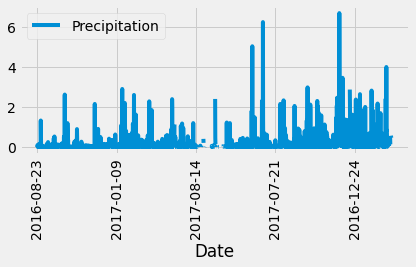

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days = 365.24)
print(year_ago)
# Perform a query to retrieve the date and precipitation scores
precipitation = session.query(Measurement.date, Measurement.prcp).\
                filter(Measurement.date >= year_ago)


# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(precipitation , columns = ['Date' , 'Precipitation'])
precipitation_df.set_index('Date' , inplace = True)


# Sort the dataframe by date
precipitation_df.sort_values(by = 'Date')
precipitation_df

# Use Pandas Plotting with Matplotlib to plot the data

precipitation_df.plot.line()
plt.xticks(rotation = 90)
plt.tight_layout()
plt.savefig("Precipitation.png",bbox_inches="tight")
plt.show()


In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
total_count = precipitation_df['Precipitation'].count()
total_rain = precipitation_df['Precipitation'].sum()
avg_rain = precipitation_df['Precipitation'].mean()
med_rain = precipitation_df['Precipitation'].median()
std_dev = precipitation_df['Precipitation'].std()
print(F'Count for rainfall measurements for the year is: {total_count}')
print(F'Total rainfall for the year is: {total_rain}')
print(F'The average rainfall for the year is: {avg_rain}')
print(F'The median rainfall for the year is: {med_rain}')
print(F'The standard deviation for rainfall for the year is: {std_dev}')

Count for rainfall measurements for the year is: 2021
Total rainfall for the year is: 358.28
The average rainfall for the year is: 0.17727857496288965
The median rainfall for the year is: 0.02
The standard deviation for rainfall for the year is: 0.4611895038877035


# Exploratory Station Analysis

In [15]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [16]:
# Design a query to calculate the total number stations in the dataset
#Based on station file     
total_stat = session.query(Station.station).count()
print(total_stat)

#Based on measurement file
results = session.query(Measurement.station).\
            group_by(Measurement.station).count()

print(results)

9
9


In [17]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station).label('total_count')).\
            group_by(Measurement.station).\
            order_by(desc('total_count')).\
            all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
session.query(Measurement.station, func.min(Measurement.tobs).label("Lowest"), func.max(Measurement.tobs).label("Highest"), func.avg(Measurement.tobs).label("Average")).\
            filter_by(station = 'USC00519281').all()


[('USC00519281', 54.0, 85.0, 71.66378066378067)]

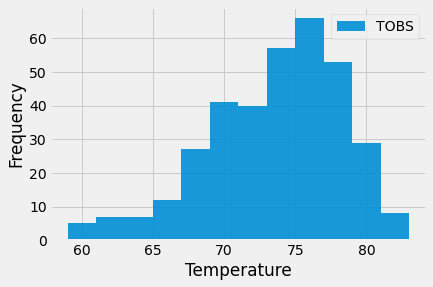

In [19]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperatures = session.query(Measurement.date, Measurement.tobs, Measurement.station).\
                filter(Measurement.station == 'USC00519281' ).\
                filter(Measurement.date >= year_ago)
temperature_df = pd.DataFrame(temperatures , columns = ['Date' , 'TOBS', 'Station'])
temperature_df.plot.hist(bins= 12, alpha = 0.9)
plt.xlabel("Temperature")
plt.savefig("TOBS.png",bbox_inches="tight")
plt.show()

# Close session

In [20]:
# Close Session
session.close()